Core Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D,
    ZeroPadding2D, Activation, Dense, Flatten, Input, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
from keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Add
from keras.models import Model
from keras.regularizers import l2
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
# Load and process genre_class.txt
data_classes = pd.read_csv(genres_datapath+'/genre_class.txt')
data_classes = {}
with open(genres_datapath + '/genre_class.txt', 'r') as f:
    for line in f:
        index, label = line.strip().split(' ', 1)
        data_classes[int(index)] = label
print(data_classes)

{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}


In [3]:
# Load train and validation data
data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
# Map labels to class names in train data
data_train['class_name'] = data_train['genre'].map(data_classes)
data_valid['class_name'] = data_valid['genre'].map(data_classes)
data_train.head()

,filename,genre,class_name
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,landscape
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,illustration
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,portrait
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,sketch_and_study
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,portrait


In [5]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename      0
genre         0
class_name    0
dtype: int64

validation:
filename      0
genre         0
class_name    0
dtype: int64


In [6]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 423
Number of invalid files in valid data: 193


In [7]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")


Number of valid rows in train after cleaning: 45079
Number of valid rows in valid after cleaning: 19298


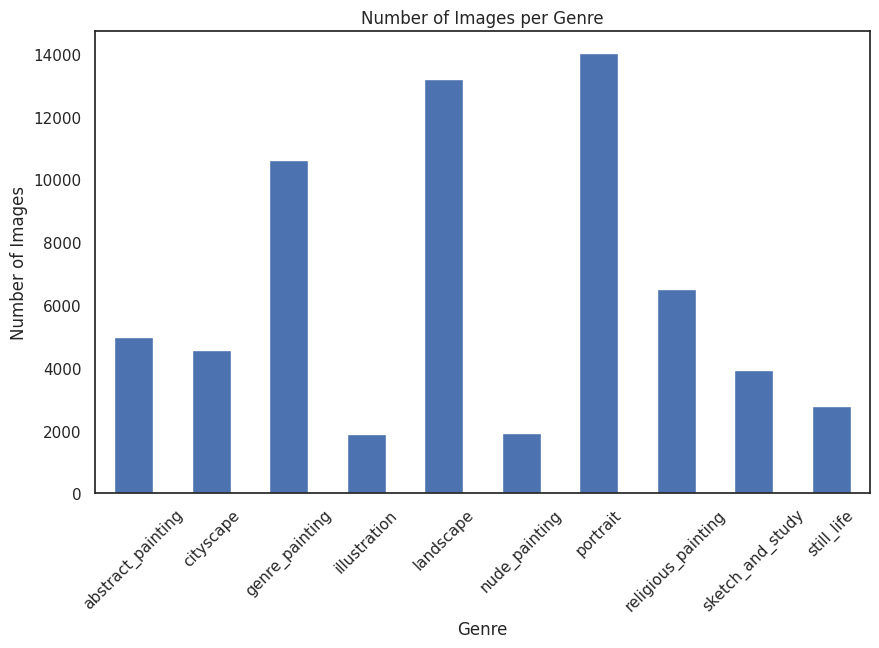

In [8]:
# Visualize the genres distribution
combined_data = (data_train_cleaned['class_name'].value_counts() + data_valid_cleaned['class_name'].value_counts())
combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("Number of Images per Genre")
plt.ylabel("Number of Images")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()

In [9]:
# Split the training data into training and testing sets (80% train, 20% test)
data_train, data_test = train_test_split(data_train_cleaned, test_size=0.2, random_state=42, stratify=data_train_cleaned['genre'])
print(data_train.shape)
print(data_valid_cleaned.shape)
print(data_test.shape)

(36063, 3)
(19298, 3)
(9016, 3)


In [10]:
# Balance classes for training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_train['class_name']),
    y=data_train['class_name']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 1.2962976276060387, 1: 1.4120203602192638, 2: 0.6066105971404542, 3: 3.415056818181818, 4: 0.48746958637469584, 5: 3.3672268907563025, 6: 0.45928425878757007, 7: 0.9888401425829448, 8: 1.6399727148703955, 9: 2.3132135984605515}


In [11]:
# Apply augmentation on training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_train,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

# Validation generator
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=data_valid_cleaned,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

# Testing generator
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_test,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 36063 validated image filenames belonging to 10 classes.
Found 19298 validated image filenames belonging to 10 classes.
Found 9016 validated image filenames belonging to 10 classes.


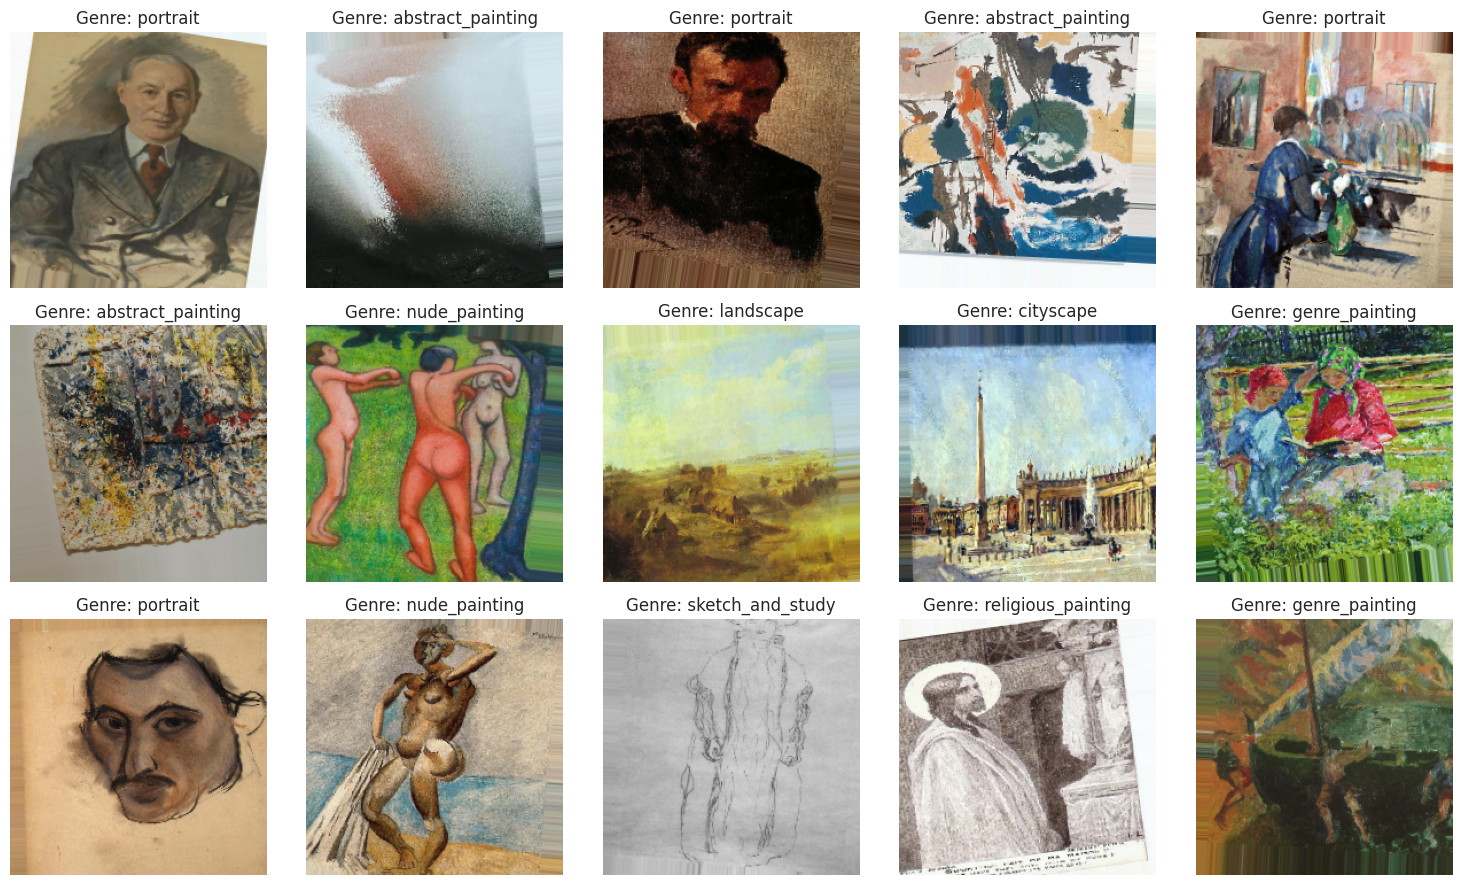

In [12]:
# Visualize images and labels from a batch of the train generator
image_batch, label_batch = next(train_generator)
plt.figure(figsize=(15, 9))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(image_batch[i])
    plt.title(f"Genre: {data_classes[np.argmax(label_batch[i])]}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

ResNet Model from Scratch:

In [6]:
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        shortcut = data  # The shortcut branch is the input
        # First block of 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data) #Normalizes the input to Reduces the chance of vanishing gradients
        act1 = Activation("relu")(bn1)#ReLU sets all negative values to zero
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)#convolution process image to extract features such as edges, corners
        # Second block of 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)
        # Third block of 1x1 CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
        # If reduction is needed, apply a CONV layer to the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)
        # Add the shortcut to the final CONV result
        x = Add()([conv3, shortcut])
        return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(inputs)
        x = Conv2D(filters[0], (7, 7), use_bias=False, padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D((3, 3), strides=(2, 2),padding="same")(x)
        for i in range(len(stages)):
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride, chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
            for j in range(stages[i] - 1):
                x = ResNet.residual_module(x, filters[i + 1], (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)
        model = Model(inputs, x, name="resnet")
        return model

BS = 32
EPOCHS = 15
height, width, depth = 224, 224, 3
classes = 10
stages = [2, 2, 2]
filters = [16, 32, 64, 128]

model = ResNet.build(width, height, depth, classes, stages, filters)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()


Model: "resnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 3)    │             12 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │          2,352 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 16)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 16)   │             64 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 8)    │            128 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 8)    │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 8)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 8)    │            576 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 8)    │             32 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 8)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │            256 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 32)   │            512 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)            

 Total params: 70,470 (275.27 KB)

 Trainable params: 69,056 (269.75 KB)

 Non-trainable params: 1,414 (5.52 KB)

In [14]:
history_model_resnet = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734535040.793927      98 service.cc:145] XLA service 0x7a0df0002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734535040.793985      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734535040.793989      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734535060.072955      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1909s 2s/step - accuracy: 0.3793 - loss: 1.8781 - val_accuracy: 0.4796 - val_loss: 1.5794
Epoch 2/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1265s 1s/step - accuracy: 0.4801 - loss: 1.5577 - val_accuracy: 0.4943 - val_loss: 1.5398
Epoch 3/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1123s 992ms/step - accuracy: 0.5013 - loss: 1.5035 - val_accuracy: 0.5082 - val_loss: 1.4879
Epoch 4/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1122s 991ms/step - accuracy: 0.5211 - loss: 1.4477 - val_accuracy: 0.5327 - val_loss: 1.4192
Epoch 5/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1111s 981ms/step - accuracy: 0.5311 - loss: 1.4085 - val_accuracy: 0.5321 - val_loss: 1.4257
Epoch 6/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1130s 998ms/step - accuracy: 0.5449 - loss: 1.3704 - val_accuracy: 0.5387 - val_loss: 1.4103
Epoch 7/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.5508 - loss: 1.3598 - val_accuracy: 0.5468 - val_loss: 1.3917
Epoch 8/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1117s 987ms/step - accuracy: 0.56

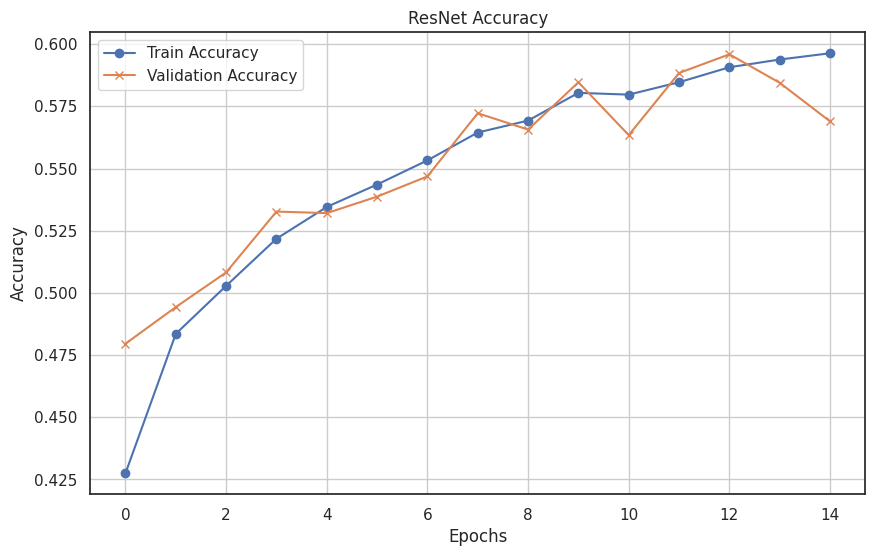

In [19]:
def plot_accuracy(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_accuracy(history_model_resnet, 'ResNet')

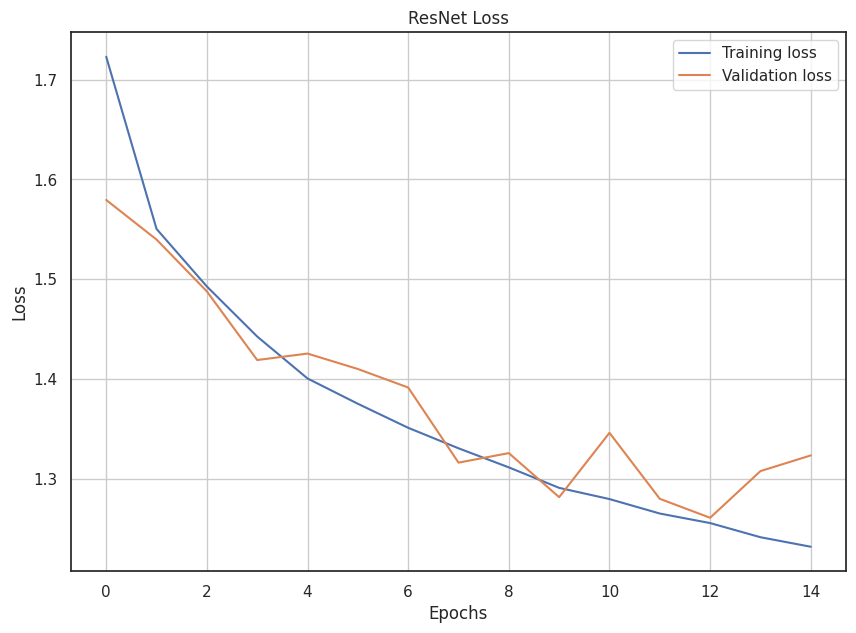

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(10, 7))

# Plot Loss
plt.plot(history_model_resnet.history['loss'], label='Training loss')
plt.plot(history_model_resnet.history['val_loss'], label='Validation loss')
plt.title('ResNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [15]:
#Display classification report
def display_classification_report(y_true, y_pred, model_name):
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

def evaluate_predictions(model, valid_generator):
    y_true = valid_generator.classes
    y_pred_probs = model.predict(valid_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    return y_true, y_pred

def call_classification_report(model, valid_generator, model_name):
    y_true, y_pred = evaluate_predictions(model, valid_generator)
    display_classification_report(y_true, y_pred, model_name)

call_classification_report(model, test_generator, 'ResNet')

282/282 ━━━━━━━━━━━━━━━━━━━━ 248s 871ms/step
Classification Report for ResNet:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       695
           1       0.41      0.69      0.52       639
           2       0.49      0.26      0.34      1486
           3       0.28      0.63      0.39       264
           4       0.79      0.57      0.66      1850
           5       0.59      0.13      0.21       268
           6       0.64      0.79      0.71      1963
           7       0.46      0.54      0.50       912
           8       0.47      0.59      0.52       550
           9       0.55      0.33      0.42       389

    accuracy                           0.56      9016
   macro avg       0.54      0.52      0.49      9016
weighted avg       0.59      0.56      0.55      9016



In [16]:
# Predict the model on the test dataset
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 197s 700ms/step
Accuracy: 0.56


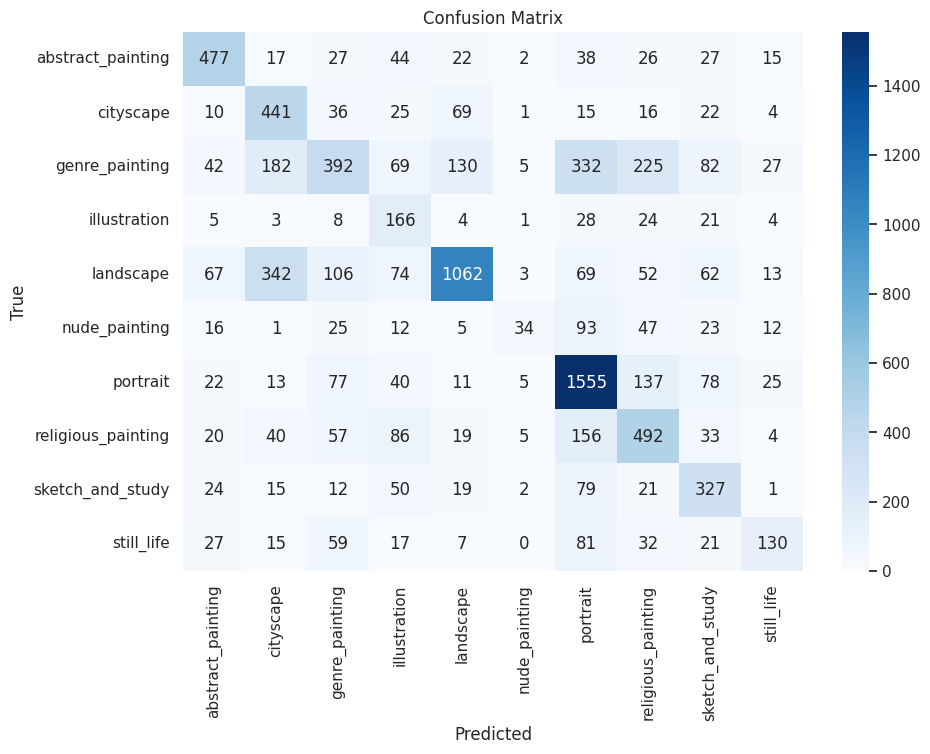

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

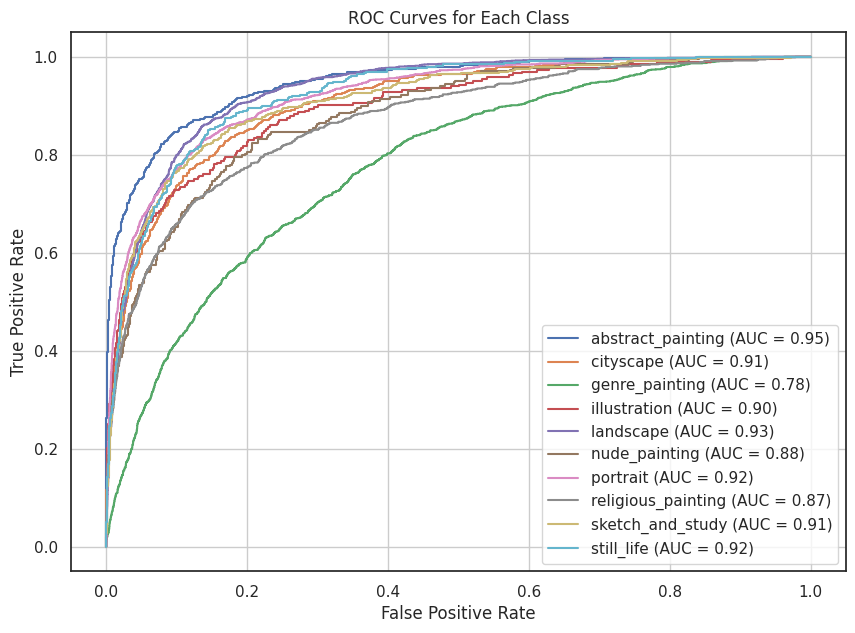

In [18]:
# ROC and AUC for each class
plt.figure(figsize=(10, 7))
y_true_arr =np.array(y_true)
for i in range(len(class_labels)):
    y_true_binary = (y_true_arr == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='best')
plt.grid()
plt.show()